# Рынок заведений общественного питания Москвы

## 1. Вводные

### 1.1. Задача
Заказчик решил открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Инвесторов интересует текущее положение дел на рынке: можно ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

Есть открытые данные о заведениях общественного питания в Москве. Необходимо подготовить исследование рынка. 

### 1.2. Описание данных
Таблица rest_data:

- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

## 2. Обзор и предобработка данных

### 2.1. Подготовка к анализу и загрузка данных 

In [1]:
pip install seaborn -U

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'  # переключаем на векторную графику

import warnings
warnings.simplefilter('ignore')  # отключаем предупредения Anaconda

from functools import partialmethod
pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine='python')  # просим query() всегда работать
                                                                         # с параметром engine='python'

In [3]:
# Локальные адреса файлов
try:
    rest = pd.read_csv('rest_data.csv')

# Адреса в тренажёре
except:  
    rest = pd.read_csv('/datasets/rest_data.csv')
    
# Сохраним исходные данные
rest_clear = rest.copy()

In [4]:
# Познакомимся с данными
rest.info()
rest.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


id             object_name chain object_type  \
0  151635                 СМЕТАНА   нет        кафе   
1   77874                  Родник   нет        кафе   
2   24309         Кафе «Академия»   нет        кафе   
3   21894              ПИЦЦЕТОРИЯ    да        кафе   
4  119365  Кафе «Вишневая метель»   нет        кафе   

                                             address  number  
0         город Москва, улица Егора Абакумова, дом 9      48  
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35  
2          город Москва, Абельмановская улица, дом 6      95  
3            город Москва, Абрамцевская улица, дом 1      40  
4  город Москва, Абрамцевская улица, дом 9, корпус 1      50

In [5]:
# Назовём столбцы более лаконично и понятно
rest.columns = ['id', 'name', 'chain', 'type', 'address', 'seats']

In [6]:
# Преобразуем все строки к нижнему регистру
for column in ['name', 'chain', 'type', 'address']:
    rest[column] = rest[column].str.lower()

rest.head()

id                    name chain  type  \
0  151635                 сметана   нет  кафе   
1   77874                  родник   нет  кафе   
2   24309         кафе «академия»   нет  кафе   
3   21894              пиццетория    да  кафе   
4  119365  кафе «вишневая метель»   нет  кафе   

                                             address  seats  
0         город москва, улица егора абакумова, дом 9     48  
1  город москва, улица талалихина, дом 2/1, корпус 1     35  
2          город москва, абельмановская улица, дом 6     95  
3            город москва, абрамцевская улица, дом 1     40  
4  город москва, абрамцевская улица, дом 9, корпус 1     50

In [7]:
# Проверим наличие дубликатов в chain
rest['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

In [8]:
# Проверим наличие дубликатов в object_type
rest['type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: type, dtype: int64

In [9]:
# Проверим наличие явных дубликатов по строкам
rest.duplicated().sum()

0

In [10]:
def simple_str(df, columns, replace_dictionary=dict(), ignore_defaults=False):

    """ Функция убирает или заменяет лишние символы в строке для упрощения поиска дубликатов
    """
    
    if not ignore_defaults:
        default = {  # Cловарь замен по-умолчанию
            'ё': 'е',
            '\"': '',
            '\'': '',
            '«': '',
            '»': '',
            ',': '',
            '.': '',
            '№': '',
            '(': '',
            ')': '',
            '-': ' ',
            '&': ' ',
            '     ': ' ',
            '    ': ' ',
            '   ': ' ',
            '  ': ' ',
        }
    
        # Добавляем умолчания в передаваемый словарь (сначала замены по пользовательскому словарю)
        replace_dictionary.update(default)
    
    for column in columns:
        for key in replace_dictionary:
            df[column] = df[column].str.replace(key, replace_dictionary[key])

In [11]:
# Уберём лишние символы из name и address перед поиском дубликатов
simple_str(rest, [
    'name',
    'address'
],{
    '-я': '',
    '-й': '',
})
rest.sample(10)

id                         name chain  \
13367  199101                     суши сет    да   
2023   152095  столовая при гбоу школа 171   нет   
2226   144105              кальянная шишка   нет   
3743    21881           кп мэи кафе дом 13   нет   
10238  180669                  донар кебаб   нет   
13130  196344                   vip pyanik   нет   
4172    83970               кафе чайхона 1    да   
9319   167272              кафе прайм стар   нет   
2574    27616             столовая шк 1206   нет   
7677    28101        оао фаберлик косметик   нет   

                                    type  \
13367                               кафе   
2023                            столовая   
2226                                кафе   
3743                                кафе   
10238                         закусочная   
13130  предприятие быстрого обслуживания   
4172                                кафе   
9319                                кафе   
2574                            столовая   
7677                            столовая   

                                                 address  seats  
13367  город москва поселение сосенское поселок комму...     16  
2023         город москва комсомольский проспект дом 47а     20  
2226   город москва большая садовая улица дом 14 стро...     40  
3743   город москва красноказарменная улица дом 13 ст...     50  
10238                 город москва улица вавилова дом 15      0  
13130              город москва ореховый бульвар дом 22а      0  
4172    город москва таганская площадь дом 12 строение 5    225  
9319   город москва пресненская набережная дом 8 стро...     38  
2574       город москва литовский бульвар дом 3 корпус 3    103  
7677               город москва никопольская улица дом 4     45

In [12]:
# Проверим наличие дубликатов в парах object_name и address
rest[['name', 'address']].duplicated().sum()

231

In [13]:
# Посмотрим на задублированные точки с одинаковым названием и адресом
rest[rest[['name', 'address']].duplicated(keep=False)].sort_values(by=['name', 'address']).head(10)

id          name chain                               type  \
2802    67936         chips   нет                               кафе   
10755  178813         chips   нет                                бар   
8004   153873  eat and talk   нет                           ресторан   
8005   154087  eat and talk   нет                           ресторан   
11654  173532     fresh bar   нет  предприятие быстрого обслуживания   
11662  173417     fresh bar   нет                                бар   
6371   135225      il patio   нет                           ресторан   
6372   135231      il patio   нет                           ресторан   
5679    27122           kfc    да                           ресторан   
12078  177203           kfc    да  предприятие быстрого обслуживания   

                                                 address  seats  
2802             город москва улица кузнецкий мост дом 7    190  
10755            город москва улица кузнецкий мост дом 7     90  
8004   город москва улица воздвиженка дом 4/7 строение 2     80  
8005   город москва улица воздвиженка дом 4/7 строение 2     10  
11654  город москва комсомольская площадь дом 6 соору...      0  
11662  город москва комсомольская площадь дом 6 соору...      0  
6371      город москва манежная площадь дом 1 строение 2     89  
6372      город москва манежная площадь дом 1 строение 2     45  
5679       город москва большая семеновская улица дом 16     25  
12078      город москва большая семеновская улица дом 16    120

In [14]:
# Посмотрим, как часто нет разницы в типе объекта
rest[['name', 'address', 'type']].duplicated().sum()

187

In [15]:
# И в информации, сетевое ли заведение
rest[['name', 'address', 'type', 'chain']].duplicated().sum()

186

Разберёмся с ситуацией, когда тип объекта и флаг «сети» совпадает.

Объединим такие строки в одну, взяв:
- среднее число посадочных мест
- минимальный id

In [16]:
# Cоздадим датафрейм задублированных строк с «правильными» данными 
duplicated_strings = (
    rest[rest[['name', 'address', 'type', 'chain']].duplicated(keep=False)]
    .groupby(['name', 'address', 'type', 'chain'], as_index=False)
    .agg({
        'id': 'min',
        'seats': 'mean',
    })
)
duplicated_strings['seats'] = duplicated_strings['seats'].astype('int')

duplicated_strings.shape

(128, 6)

In [17]:
# И датафрейм с остальными строками
not_duplicated_strings = rest[np.logical_not(rest[['name', 'address', 'type', 'chain']].duplicated(keep=False))]
not_duplicated_strings.shape

(15052, 6)

In [18]:
# И соединим их, таким образом убрав дубликаты упомянутого выше типа
rest = pd.concat([not_duplicated_strings, duplicated_strings])
rest.info()
rest.sample()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15180 entries, 0 to 127
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       15180 non-null  int64 
 1   name     15180 non-null  object
 2   chain    15180 non-null  object
 3   type     15180 non-null  object
 4   address  15180 non-null  object
 5   seats    15180 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 830.2+ KB


id  name chain  type                                        address  \
2544  26286  такэ   нет  кафе  город москва проспект 60 летия октября дом 20   

      seats  
2544     68

Отлично, избавились от дубликатов упомянутого типа.

Теперь разберёмся с флагом «сеть».

In [19]:
# Посмотрим, что за заведение с такой проблемой
rest[rest[['name', 'address', 'type']].duplicated(keep=False)]

id                 name chain      type  \
11604  177051  ресторан хинкальная   нет  ресторан   
11972  176949  ресторан хинкальная    да  ресторан   

                                       address  seats  
11604  город москва автозаводская улица дом 18      0  
11972  город москва автозаводская улица дом 18     60

In [20]:
# Посмотрим, есть ли ещё заведения с таким названием
rest.query("name == 'ресторан хинкальная'")

id                 name chain      type  \
5391    71371  ресторан хинкальная    да  ресторан   
11604  177051  ресторан хинкальная   нет  ресторан   
11972  176949  ресторан хинкальная    да  ресторан   

                                           address  seats  
5391   город москва проспект мира дом 211 корпус 2     25  
11604      город москва автозаводская улица дом 18      0  
11972      город москва автозаводская улица дом 18     60

In [21]:
# Похоже, что строчка 11604 — лишняя
try:  # чтобы повторный запуск ячеки при отладке не приводил к ошибке
    rest.drop(index=11604, inplace=True)
except:
    None

In [22]:
# Проверим результат
rest.query("name == 'ресторан хинкальная'")

id                 name chain      type  \
5391    71371  ресторан хинкальная    да  ресторан   
11972  176949  ресторан хинкальная    да  ресторан   

                                           address  seats  
5391   город москва проспект мира дом 211 корпус 2     25  
11972      город москва автозаводская улица дом 18     60

In [23]:
# Оценим, скольно теперь точек с одинаковым названием и адресом
rest[['name', 'address']].duplicated().sum()

44

Определить их точный тип можно только вручную.

При этом возможны ситуации, когда в источнике данных были теги, например, и кафе, и ресторана, от этого оно упомянуто дважды с разной оценкой посадочных мест.

А возможно там есть зона как кафе, так и ресторана, например, есть два зала.

Разобраться в этом будет сложно.

Это всего 44 места из более чем 10000, так что просто удалим эти строки, они не повлияют на общую картину.

In [24]:
# Удалим строки с задублированными названием и адресом
rest.drop(index=rest[rest[['name', 'address']].duplicated(keep=False)].index, inplace=True)
rest.shape

(15080, 6)

In [25]:
# Проверим, что все id уникальны
rest['id'].duplicated().sum()

0

In [26]:
# Валидация id на положительность
rest[rest['id'] <= 0]

Empty DataFrame
Columns: [id, name, chain, type, address, seats]
Index: []

In [27]:
# Валидация числа посадочных мест на неотрицательность
rest[rest['seats'] < 0]

Empty DataFrame
Columns: [id, name, chain, type, address, seats]
Index: []

In [28]:
# Посмотрим на распределение числа посадочных мест
rest['seats'].hist(bins=100, figsize=(6, 1))
plt.show()

In [29]:
# Оценим реалистичность 
rest.query("seats > 1000")

id                                      name chain      type  \
2313    26560                            ресторан альфа   нет  ресторан   
3686    27026                                рум сервис   нет  ресторан   
4480    27024                                рум сервис   нет  ресторан   
8148    80291                        банкетный зал шелк   нет  ресторан   
8345    27750                            столовая буфет   нет  столовая   
9064    19719  комбинат питания управление академсервис   нет  столовая   
12723  199696                      arena by soho family   нет       бар   

                                                 address  seats  
2313     город москва измайловское шоссе дом 71 корпус а   1040  
3686                   город москва площадь европы дом 2   1200  
4480   город москва кутузовский проспект дом 2/1 стро...   1200  
8148   город москва большой саввинский переулок дом 1...   1500  
8345                  город москва улица волхонка дом 15   1400  
9064   город москва проспект вернадского дом 84 строе...   1288  
12723  город москва кутузовский проспект дом 36 строе...   1700

Поиск показывает, что в Арену поместится 2600 человек. Будем считать данные реалистичными. 

In [30]:
# Валидация на непустоту названия
rest.query("name == ''")

Empty DataFrame
Columns: [id, name, chain, type, address, seats]
Index: []

In [31]:
# Валидация на непустоту адреса
rest.query("address == ''")

Empty DataFrame
Columns: [id, name, chain, type, address, seats]
Index: []

In [32]:
# Проверим, если ли дубли в названиях сетей
# chain_names = rest.query("chain == 'да'").groupby('name', as_index=False).agg({
#     'id': 'count',
# })

# print(*chain_names['name'].values, sep='\n')

In [33]:
# Исправим вручную очевидные дубли, начнём с префиксов
simple_str(rest, ['name'],{
    
    # Сначала составные
    'бистро ': '',
    'детский клуб ': '',
    'детское кафе ': '',
    'кальян бар ': '',
    'кафе пекарея ': '',
    'кафе пекарня ': '',
    'кафе при азс ': '',
    'кондитерская пекарня ': '',
    'магазин кулинария ': '',
    'магазин готовой еды ': '',
    'предприятие быстрого обслуживания ': '',
    'предприятие быстрого питания ': '',
    'при азс ': '',
    'быстрого питания ': '',
    'ресторан быстрого питания ': '',
    'ресторан японской кухни ': '',
    'семейное кафе и кондитерская ': '',
    'семейное кафе ': '',
    'сеть магазинов ': '',
    'семейный ресторан ': '',
    'спорт бар ': '',
    'стейк хаус ': '',
    'суши бар ': '',
    'готовые блюда ': '',
    'точка продажи готовой еды ': '',
    'фитнес бар ': '',
    'чешская пивная ': '',

    # Потом однословные
    'бар ': '',
    'закусочная ': '',
    'кальянная ': '',
    'кафе ': '',
    'каффе ': '',
    'кондитерия ': '',
    'кондитерская ': '',
    'кофейня ': '',
    'паб ': '',
    'пбо ': '',
    'пончиковое ': '',
    'пицерия ': '',
    'пиццерия ': '',
    'пицца ': '',
    'ресторан ': '',
    'траттория ': '',
    'тратория ': '',
#    'хинкальная': '', — не используем, слово есть в названиях
    
}, ignore_defaults=True)


# Посмотрим на названия сетей
# chain_names = rest.query("chain == 'да'").groupby('name', as_index=False).agg({
#     'id': 'count',
# })

# print(*chain_names['name'].sort_values().values, sep='\n')

In [34]:
# Исправим вручную отдельные названия 
simple_str(rest, ['name'],{
    
    'алло 2': 'алло',
    'алло пицца': 'алло',
    'алло пицца 2': 'алло',
    
    'ав дейли азбука вкуса': 'азбука вкуса',
    
    'кулинарная лавка братьев караваевых братья караваевы': 'братья караваевы',
    'кулинарная лавка братьев караваевых': 'братья караваевы',
    'братья караваевых': 'братья караваевы',

    'бир хаус паб': 'бир хаус',

    'кофешоп coffeeshop company': 'coffeeshop',
    'coffeeshop company': 'coffeeshop',

    'ресторанвьеткафе': 'вьеткафе',
    'vietcafe вьеткафе': 'вьеткафе',

    'кулинарное бюро kitchen': 'kitchen',
    'кулинарное бюро китчен': 'kitchen',
    'кулинарное бюро': 'kitchen',

    'ресторанмакдоналдс': 'макдоналдс',
    'москва макдоналдс': 'макдоналдс',
    
    'магбургер азс 16': 'магбургер',    
    'магбургер азс 17': 'магбургер',    

    'мск московская сеть кальянных на шаболовке': 'мск московская сеть кальянных',    

    'мята lounge автозаводская': 'мята',    
    'мята lounge октябрьская': 'мята',    
    'мята lounge шаболовка': 'мята',  
    'мята lounge': 'мята',    
    
    'deli by prime прайм кафе': 'prime_star',
    'prime прайм стар прайм кафе': 'prime_star',
    'prime star прайм стар': 'prime_star',
    'prime star prime star': 'prime_star',
    'prime starprime star': 'prime_star',
    'prime прайм стар': 'prime_star',
    'праймпрайм стар': 'prime_star',
    'прайм прайм стар': 'prime_star',
    'прайм стар кафе': 'prime_star',
    'прайм стар': 'prime_star',
    'праймстар': 'prime_star',
    'прайм кафе': 'prime_star',
    'prime star': 'prime_star',
    'прайм': 'prime_star',

    'бургер кинг burger king': 'бургер кинг',
    
    'starbucks старбакс кофе': 'starbucks',  
    'starbucks coffee': 'starbucks',     
    'starbucks кофе': 'starbucks',     
    'starbucks старбакс': 'starbucks',     
    'старбакс starbucks': 'starbucks',
    'старбакс кофе': 'starbucks',
    'старбакс': 'starbucks',
   
    'torro grill торро гриль': 'торро гриль',
    
    'tgi fridays': 'fridays',
    
    'tutti frutti frozen yogurt': 'tutti frutti',
    'мороженного tutti frutti': 'tutti frutti',
    
    'мимино хинкальная': 'мимино',
    
    'travelers coffee': 'travelers_coffee',
    'travelers coffe': 'travelers_coffee',   
     
    'лукойл центрнефтьпродукт': 'лукойл',

    'нияма пицца пи': 'нияма',

    'павлин мавлин чайхона 1': 'павлин мавлин',

    'папа джонс пицца': 'папа джонс',

    'kfc покрышкина': 'kfc',
    'ростикс kfc': 'kfc',
    'kfc волгоградский': 'kfc',

    'пироги штолле': 'штолле',
    'пироговая штолле': 'штолле',

    'pomodoro и суши дзен': 'pomodoro',

    'паоло и бенто wok': 'паоло',

    'пончиковое кафе икеа ikea': 'ikea',
    'икеа ikea': 'ikea',

    'сабвей': 'subway',
    'сабвей subway': 'subway',

    'советские времена чебуречная ссср': 'советские времена',
    'чебуречная ссср': 'советские времена',

    'стардогs': 'стардогs',
    'стардогs и шаурма': 'стардогs',
    'стардогс стардогs': 'стардогs',
         
    'старина мюллер старина миллер': 'старина миллер',

    'гудман гудвин': 'гудман',
    'goodman гудман': 'гудман',

    'суши вок': 'суши wok',

    'van wok ванвок': 'vanwok',
    'vanwok ванвок': 'vanwok',
    'ванвок': 'vanwok',
    
    'теремок инвест': 'теремок',

    'территория timbigfamily': 'территория',
    'территория ясенево': 'территория',
    
    'урюк вавилова': 'урюк',
    'grand урюк': 'урюк',
    'урюк хивинская чайхона': 'урюк',
    'вгости урюк': 'урюк',
    'чайхана урюк': 'урюк',
    
    'кафе волконский пекарня': 'волконский',
    'волконский пекарня': 'волконский',
 
# хинкальная 1 — отдельная сеть https://xinkalnaya1.ru/
# хинкальная city — отдельная сеть https://hinkali.city/
# хинкальная кинто — отдельная сеть  http://www.kinto.su/

    'чайхона 1 бутово': 'чайхона 1',
    
    'шантимель кондитерские': 'шантимель',
    
    'иль патио планета суши': 'il patio',
    'иль патио il patio': 'il patio',
    'il patio il patio': 'il patio',
    'иль патио': 'il patio',
    
    'кофе хаус экспрессо и капучино бар': 'кофе хаус',
    'кофе хаусэкспресс': 'кофе хаус',
    
    'кофемания бармалини': 'кофемания', # бармалини — не сеть https://barmalini.ru/
    
    'il forno иль форно': 'il forno',

    'krispy creme': 'krispy krem',

    'бб энд бургерс в в бургер': 'в в бургер',

    'subway subway': 'subway',

    'upside down cake': 'upside down',
    
    'американ сити пицца': 'американ сити',
    'американ сити цех по изготовлению пиццы': 'американ сити',
    
    'анти moskalyan': 'moskalyan',
    
    'да пино da pino': 'да пино',
    
    'дабл би блэк': 'дабл би',  
    
    'кофе с собой кофейня': 'кофе с собой',
    
    'пиппони': 'пипони',
    
    'сити пицца': 'сити',
    
    'суши маки маки': 'маки маки',
    'японской кухни маки маки': 'маки маки',
    'maki maki': 'маки маки',
    
    'суши тун хруст pizza кофе тун': 'суши тун',
    
    'чайхана тапчан': 'тапчан',
    
    'японский ваби саби': 'ваби саби',   
    
    'якитория и спорт бар': 'якитория',
    'якитория и ян примус': 'якитория',
    
    'газпромнефтьцентр': 'газпромнефть',
    
# джардино да пино - не дубль    # отдельная сеть — https://giardinodipino.ru/
                                 # отдельная сеть — https://dapino.ru/

    
}, ignore_defaults=True)


# Посмотрим на результат
# chain_names = rest.query("chain == 'да'").groupby('name', as_index=False).agg({
#     'id': 'count',
# })

# print(*chain_names['name'].sort_values().values, sep='\n')

Есть ряд задублированных названий, проверим их в гугле.

In [35]:
# subway сушивок — тут оба заведения с объединённым залом https://yandex.ru/profile/1471666606
rest.query("name == 'subway сушивок'")

id            name chain  type  \
2671  124655  subway сушивок    да  кафе   

                                              address  seats  
2671  город москва ботаническая улица дом 29 корпус 1     24

 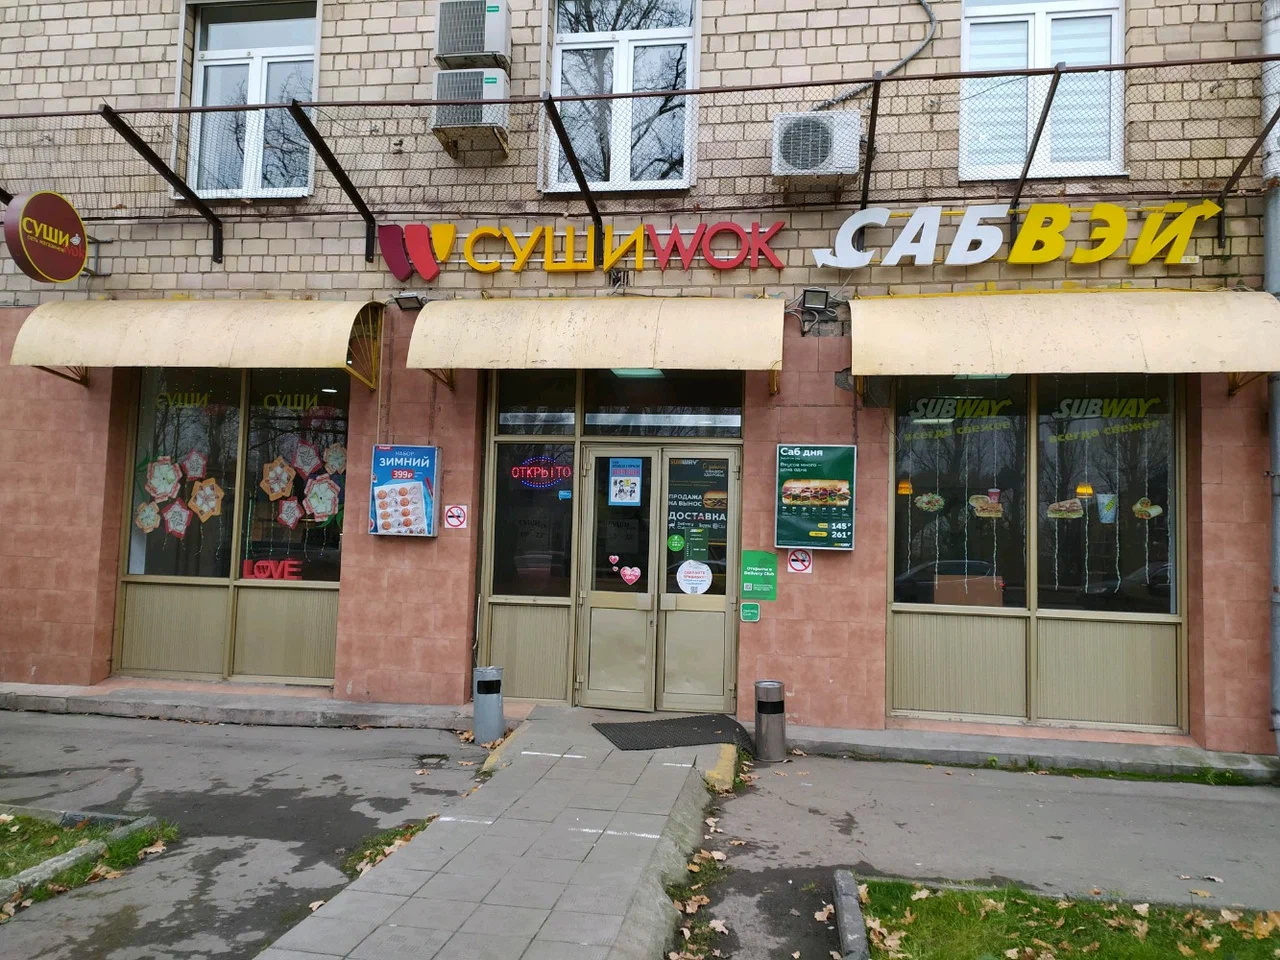

In [36]:
def split_string(df, rest_id, names):   
    
    """ На основании строки с указанным id создаёт несколько аналогичных
        с новыми названиями точек. За первым сохраняется преждний id,
        остальным присваиваются новые, уникальные.
        Индекс датафрейма при этом сбрасывается.
    """
    
    n = len(names)
    string = df.loc[df['id'] == rest_id]

    new_string = pd.DataFrame({
        'id': np.concatenate((string.id.values, np.arange(rest['id'].max() + 1, rest['id'].max() + n))),
        'name': names,
        'chain': list(string.chain.values) * n,
        'type': list(string.type.values) * n,
        'address': list(string.address.values) * n,
        'seats': list(string.seats.values) * n,
    })

    df.drop(index=string.index.values[0], inplace=True)

    df = df.append(new_string, ignore_index=True)
    
    return df

In [37]:
# Разделим строку 'сушивок subway' на две отдельных
# Количество мест при этом не будем делить пополам, запишем размер зала в оба заведения
rest = split_string(rest, 124655, ['сушивок', 'subway'])

In [38]:
# Проверим, что всё прошло корректно
rest[np.logical_or(rest['id'] == 124655, rest['id'] == rest['id'].max())]

id     name chain  type  \
15079  124655  сушивок    да  кафе   
15080  223440   subway    да  кафе   

                                               address  seats  
15079  город москва ботаническая улица дом 29 корпус 1     24  
15080  город москва ботаническая улица дом 29 корпус 1     24

In [39]:
# Выполним такие замены и для остальных парных заведений
# Найдём их id
pairs = {
    'fridays kfc': ['fridays', 'kfc'],
    'кофемания starbucks': ['кофемания', 'starbucks'],
    'хачапури одесса мама': ['хачапури', 'одесса мама'],
    'баскин роббинс стардогс': ['баскин роббинс', 'стардогс'],
    'шикари il patio': ['шикари', 'il patio'],
    'шоколадница кофе хаус': ['шоколадница', 'кофе хаус'],
    'шоколадница кофемания': ['шоколадница', 'кофемания'],
    'subway starbucks': ['subway', 'starbucks'],
    'вlack burger чайхона 1': ['вlack burger', 'чайхона 1'],
    'грузинские каникулы барбарис': ['грузинские каникулы', 'барбарис'],
}

split_strings = rest.query("name in @pairs")[['id', 'name']]
split_strings

id                          name
258     25141         шоколадница кофе хаус
5624    59091              subway starbucks
7472   149858               шикари il patio
7844    96154              subway starbucks
7908    25599         шоколадница кофемания
8268    74880        вlack burger чайхона 1
9079   166809          хачапури одесса мама
11718  186100  грузинские каникулы барбарис
11763  174346       баскин роббинс стардогс
14798   25452           кофемания starbucks
14836  211435                   fridays kfc

In [40]:
# Подготовим значеия для разбивки
split_strings['pairs'] = [
    ['шоколадница', 'кофе хаус'],
    ['subway', 'starbucks'],
    ['шикари', 'il patio'],
    ['subway', 'starbucks'],
    ['шоколадница', 'кофемания'],
    ['вlack burger', 'чайхона 1'],
    ['хачапури', 'одесса мама'],
    ['грузинские каникулы', 'барбарис'],
    ['баскин роббинс', 'стардогс'],
    ['кофемания', 'starbucks'],
    ['fridays', 'kfc'],
]
split_strings

id                          name                            pairs
258     25141         шоколадница кофе хаус         [шоколадница, кофе хаус]
5624    59091              subway starbucks              [subway, starbucks]
7472   149858               шикари il patio               [шикари, il patio]
7844    96154              subway starbucks              [subway, starbucks]
7908    25599         шоколадница кофемания         [шоколадница, кофемания]
8268    74880        вlack burger чайхона 1        [вlack burger, чайхона 1]
9079   166809          хачапури одесса мама          [хачапури, одесса мама]
11718  186100  грузинские каникулы барбарис  [грузинские каникулы, барбарис]
11763  174346       баскин роббинс стардогс       [баскин роббинс, стардогс]
14798   25452           кофемания starbucks           [кофемания, starbucks]
14836  211435                   fridays kfc                   [fridays, kfc]

In [41]:
for rest_id, names in zip(split_strings['id'].values,
                          split_strings['pairs'].values):
    rest = split_string(rest, rest_id, names)

rest.tail(10)

id                 name chain                               type  \
15082  166809             хачапури    да                           ресторан   
15083  223447          одесса мама    да                           ресторан   
15084  186100  грузинские каникулы    да                           ресторан   
15085  223448             барбарис    да                           ресторан   
15086  174346       баскин роббинс    да                         закусочная   
15087  223449             стардогс    да                         закусочная   
15088   25452            кофемания    да                               кафе   
15089  223450            starbucks    да                               кафе   
15090  211435              fridays    да  предприятие быстрого обслуживания   
15091  223451                  kfc    да  предприятие быстрого обслуживания   

                                              address  seats  
15082  город москва улица шаболовка дом 14 строение 2    130  
15083  город москва улица шаболовка дом 14 строение 2    130  
15084      город москва большая тульская улица дом 13     12  
15085      город москва большая тульская улица дом 13     12  
15086           город москва бесединское шоссе дом 15      2  
15087           город москва бесединское шоссе дом 15      2  
15088       город москва 1 тверскаямская улица дом 21     65  
15089       город москва 1 тверскаямская улица дом 21     65  
15090     город москва проспект мира дом 211 корпус 2     50  
15091     город москва проспект мира дом 211 корпус 2     50

In [42]:
# «при азс» — не очень похоже на название сети 
pd.set_option('display.max_colwidth', 0)
rest.query("name == 'при азс'")

id     name chain                               type  \
5076   23158   при азс  нет   кафе                                
5237   145397  при азс  нет   кафе                                
5883   145332  при азс  да    предприятие быстрого обслуживания   
8614   145235  при азс  нет   кафе                                
15011  145221  при азс  нет   кафе                                

                                                    address  seats  
5076   город москва ярославское шоссе владение 3 строение 2  20     
5237   город москва ярославское шоссе дом 1 корпус 1         20     
5883   город москва покровская улица владение 26 строение 1  16     
8614   проезд добролюбова дом 2                              0      
15011  город москва огородный проезд дом 7 строение 1        0

In [43]:
# Проверим адрес по карте, и увидим, что это лукойл
rest.loc[5883, 'name'] = 'лукойл'
rest.query("name == 'при азс'")

id     name chain  type  \
5076   23158   при азс  нет   кафе   
5237   145397  при азс  нет   кафе   
8614   145235  при азс  нет   кафе   
15011  145221  при азс  нет   кафе   

                                                    address  seats  
5076   город москва ярославское шоссе владение 3 строение 2  20     
5237   город москва ярославское шоссе дом 1 корпус 1         20     
8614   проезд добролюбова дом 2                              0      
15011  город москва огородный проезд дом 7 строение 1        0

In [44]:
# Проверим, если ли заведения с названиями как у сетей, но без признака сети
chain_names = rest.query("chain == 'да'").groupby('name', as_index=False).agg({
    'id': 'count',
})

print(rest.query("chain == 'нет' and name in @chain_names.name.values").sort_values('name')['name'].unique())

['bocconcino' 'boobo' 'bp' 'cofix' 'correas' 'dunkin donuts' 'fridays'
 'healthy food' 'il patio' 'kfc' 'kitchen' 'osteria mario' 'prime_star'
 'semplice' 'subway' 'travelers_coffee' 'tutti frutti' 'upside down'
 'vanwok' 'wok box' 'азбука вкуса' 'академия' 'алло' 'барбарис' 'брусника'
 'бургер кинг' 'бургер клаб' 'ваби саби' 'вареничная 1' 'венеция'
 'виват пицца' 'вкусняшка' 'воккер' 'волконский' 'газпромнефть'
 'грузинские каникулы' 'гудман' 'гурман' 'две палочки' 'доминос пицца'
 'дорогая я перезвоню' 'ерш' 'квартира 44' 'козловица' 'колбасофф' 'кофе'
 'кофе бин' 'кофе с собой' 'кофепорт' 'крошка картошка' 'кружка' 'лукойл'
 'магнолия' 'марукамэ' 'милти' 'мимино' 'молли гвинз' 'му му' 'мюнгер'
 'мята' 'обжорный ряд' 'одесса мама' 'панчо пицца' 'паоло' 'папа джонс'
 'пипони' 'рецептор' 'роллофф' 'руккола' 'сити' 'сказка' 'спб' 'стардогс'
 'суши wok' 'суши сет' 'сушивок' 'тапчан' 'темпл бар' 'теремок' 'торнадо'
 'урюк' 'фабрика' 'хижина' 'хинкальная' 'хинкальная 1' 'хлеб насущный'
 '

In [45]:
# Cудя по всему, это всё тоже сетевые заведения за исключением общих названий, поправим фильтр
not_chain = {
    'кофе',
    'кофе с собой',
    'хинкальная'
}

rest.query("chain == 'нет' and name in @chain_names.name.values and name not in @not_chain").sample(10)

id             name chain      type  \
1011   157402  азбука вкуса     нет   кафе       
11217  179616  газпромнефть     нет   кафе       
2056   158192  азбука вкуса     нет   кафе       
8843   24352   шоколадница      нет   кафе       
11094  186348  мята             нет   бар        
7774   76668   тапчан           нет   ресторан   
5410   144509  лукойл           нет   кафе       
8041   157912  азбука вкуса     нет   кафе       
12695  199476  крошка картошка  нет   кафе       
10089  172886  роллофф          нет   кафе       

                                                            address  seats  
1011   город москва садовая черногрязская улица дом 13/3 строение 1  10     
11217  город москва шипиловский проезд владение 29                   5      
2056   город москва новокузнецкая улица дом 1 строение 3             10     
8843   город москва улица шаболовка дом 10 корпус 1                  48     
11094  город москва керченская улица дом 1б                          45     
7774   город москва звенигородское шоссе дом 18/20 корпус 1          56     
5410   город москва щелковское шоссе дом 102а                        2      
8041   город москва бауманская улица дом 32 строение 2               15     
12695  город москва ленинградское шоссе дом 16а строение 4           30     
10089  город москва каширское шоссе дом 142 корпус 1                 25

In [46]:
# Всё это похоже на сетевые заведения, изменим их признак сети
# rest.loc[rest['name'] in chain_names.name.values]
chain_names = rest.query("chain == 'да'")['name'].unique()

is_chain = np.logical_and(
    np.logical_and(
        [name in chain_names for name in rest['name']],
        [name not in not_chain for name in rest['name']]
    ),
    [name == 'нет' for name in rest['chain']]
)

rest.loc[is_chain, 'chain'] = 'да'

rest.loc[is_chain].sample(5)

id          name chain  type  \
8041   157912  азбука вкуса  да    кафе   
11486  179075  суши wok      да    кафе   
5486   142366  стардогс      да    кафе   
5410   144509  лукойл        да    кафе   
9948   124241  bocconcino    да    кафе   

                                                       address  seats  
8041   город москва бауманская улица дом 32 строение 2          15     
11486  город москва город щербинка симферопольское шоссе дом 8  44     
5486   город москва шоссе энтузиастов дом 31 строение 39        16     
5410   город москва щелковское шоссе дом 102а                   2      
9948   город москва большой патриарший переулок дом 4           70

Пропусков в данных — нет.

В данных большая путанница с признаком сети и названиями.

Было найдено значительное количество дубликатов и сомнительных данных, часть данных исправлена, часть — удалена. 

## 3. Анализ данных

In [47]:
# Оптимизируем построение графиков
def hbarplot(data, x, y, hue=None, order=None, title='', bar_values=False, grid=True,
             right_margin=30, up_margin=.09, fontsize=6, color='gray', legend_title=None):

    fig, ax = plt.subplots()
    plt.grid() if grid else None
    sns.barplot(
        x=x,
        y=y,
        hue=hue,
        data=data,
        order=order,
    )
    ax.set(
        title=title,
        xlabel='',
        ylabel='',
    )
    
    if bar_values:  # добавление подписей к столбцам

        colors = data[hue].nunique() if hue else 1           
        patches = ax.patches
        
        patches.sort(key=lambda patch: patch.get_y()) 
                
        # Функция, рисующая подпись к одной полоске
        def ax_text(bar, value, right_margin=right_margin, up_margin=up_margin, fontsize=fontsize, color=color):
            ax.text(
                bar.get_width() + right_margin,
                bar.get_y() + bar.get_height() - up_margin,
                value,
                fontsize=fontsize,
                ha='left',
                color=color,
            )

        if bar_values == 'group':

            groups = int(len(patches) / colors)
            bars_groups = []
            group_totals = [0] * groups

            for i in range(groups):
                bars_groups.append(patches[i * colors : (i+1) * colors])
                for bar in bars_groups[i]:
                    group_totals[i] += bar.get_width()

            for i in range(groups):
                for bar in bars_groups[i]:
                    ax_text(bar, '{0:.0%}'.format(bar.get_width() / group_totals[i]))

        if bar_values == 'color' or bar_values == True:  

            bars_colors = []
            color_totals = [0] * colors

            for i in range(colors):
                bars_colors.append(patches[i : len(patches) : colors])
                for bar in bars_colors[i]:
                    color_totals[i] += bar.get_width()

            for i in range(colors):
                for bar in bars_colors[i]:
                    ax_text(bar, '{0:.0%}'.format(bar.get_width() / color_totals[i]))

        if bar_values == 'value':
            for bar in patches:
                ax_text(bar, int(bar.get_width()))

    if legend_title: plt.legend(title=legend_title)
    sns.despine()
    plt.show()

### 3.1. Типы заведений

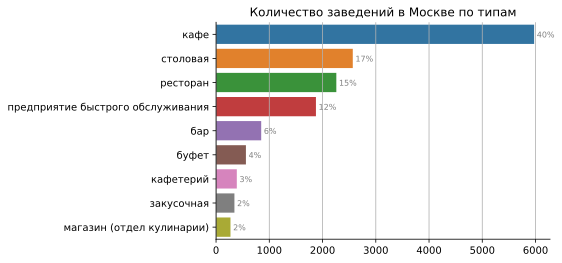

In [48]:
# Посмотрим на популярность типов заведений
hbarplot(
    rest['type'].value_counts().reset_index(),
    x='type',
    y='index',
    title='Количество заведений в Москве по типам',
    bar_values=True,
    fontsize=8,
    up_margin=.27,
    right_margin=50,
)

Кафе — самый популярный общепит.

### 3.2. Сети

#### 3.2.1. Общая доля

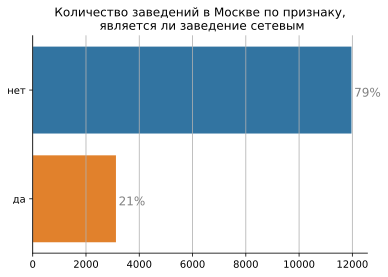

In [49]:
# Посмотрим, как много сетевых заведений
hbarplot(
    rest['chain'].value_counts().reset_index(),
    x='chain',
    y='index',
    title='Количество заведений в Москве по признаку,\n является ли заведение сетевым',
    bar_values=True,
    fontsize=12,
    up_margin=.34,
    right_margin=100,
)

Пятая часть заведений — сетевые. 

#### 3.2.2. Типы заведений 

In [50]:
# Посмотрим на тип и признак сети одновремнено
data = rest.groupby(['type', 'chain'], as_index=False).agg({
    'id': 'count'
}).sort_values('id', ascending=False)

order = data.sort_values(['chain', 'id'], ascending=[True, False])['type'].drop_duplicates()

data.head()

type chain    id
7   кафе                               нет   4473
17  столовая                           нет   2564
15  ресторан                           нет   1684
6   кафе                               да    1501
13  предприятие быстрого обслуживания  нет   1080

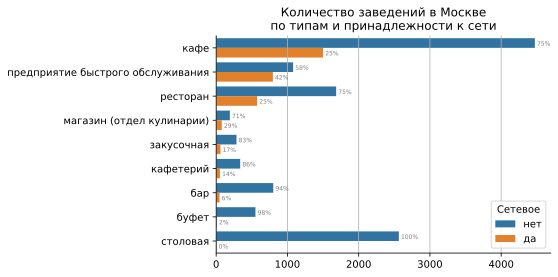

In [51]:
# И построим диаграмму
hbarplot(
    data,
    y='type',
    x='id',
    hue='chain',
    order=order,
    title='Количество заведений в Москве\nпо типам и принадлежности к сети',
    legend_title='Сетевое',
    
    bar_values='group',
)

Сетевое распространение характерно для предприятий быстрого обслуживания: 42% пбо — сетевые.

Но хоть всего четверть кафе — сетевые, в абсолютном значении их почти в 2 раза больше, чем пбо (≈1500 к 800).

#### 3.2.3. Число посадочных мест

In [52]:
# Посмотрим на соотношение размера сети и числа посадочных мест
chains = rest.groupby(['name', 'chain']).agg({
    'name': 'count',
    'seats': 'median'
})
chains.columns = ['size', 'seats_avg']
chains.reset_index(inplace=True)
chains.head()

name chain  size  seats_avg
0  01                         нет   1     96.0     
1  02                         нет   1     47.0     
2  1                          нет   2     55.0     
3  1 магазин разливного пива  нет   1     16.0     
4  1 мок                      нет   1     100.0

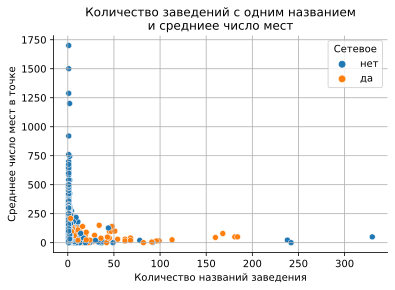

In [53]:
# Сравним на диаграмме рассеяния, распределение названий заведений по количеству таких названий и среднему числу мест
fig, ax = plt.subplots()
plt.grid()
sns.scatterplot(
    x='size',
    y='seats_avg',
    hue='chain',
    data=chains,
)
ax.set(
    title='Количество заведений с одним названием\nи средниее число мест',
    xlabel='Количество названий заведения',
    ylabel='Средннее число мест в точке',
)
plt.legend(title='Cетевое')
sns.despine()
plt.show()

In [54]:
# Интересно, что заведений с некоторыми названиями больше, чем точек в самых крупных сетях
chains.query("chain == 'нет' and size > 30").sort_values('size', ascending=False)

name chain  size  seats_avg
6529  столовая                  нет   330   50.0     
8488  шаурма                    нет   242   0.0      
3916  кафе                      нет   238   22.5     
5473  пекарня                   нет   92    2.0      
2280  буфет                     нет   78    20.0     
3433  донер кебаб               нет   49    0.0      
8821  школьно базовая столовая  нет   44    127.0    
3926  кафетерий                 нет   38    7.0      
2759  выпечка                   нет   37    0.0      
2101  бистро                    нет   35    1.0      
4277  кофейня                   нет   33    6.0

Всё в порядке, это не сети, у которых неверно указан признак сети, а маленькие «ноунейм» шаурмячные, столовые и кафе.

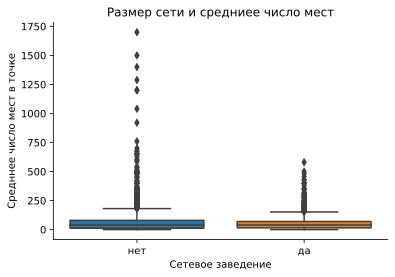

In [55]:
ax = sns.boxplot(data=rest, x='chain', y='seats')

ax.set(
    title='Размер сети и средниее число мест',
    xlabel='Сетевое заведение',
    ylabel='Средннее число мест в точке',
)
sns.despine()
plt.show()

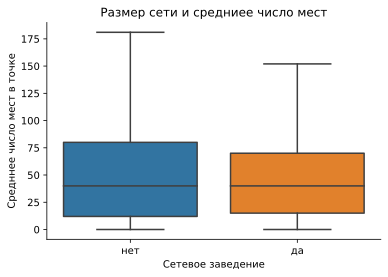

In [56]:
ax = sns.boxplot(data=rest, x='chain', y='seats', showfliers=False)

ax.set(
    title='Размер сети и средниее число мест',
    xlabel='Сетевое заведение',
    ylabel='Средннее число мест в точке',
)
sns.despine()
plt.show()

В типином заведении мест примерно столько же, сколько в сетевом.

Но есть некоторое количество уникальных одиночных заведений, в которых очень много мест, иногда больше 1000. Сетевые заведения таким размером похвастаться не могут.

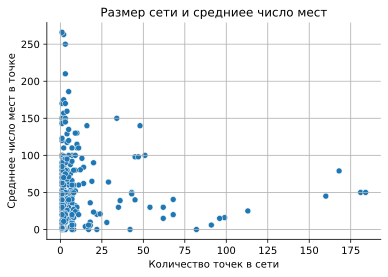

In [57]:
# Построим диаграмму рассеяния только по сетям
fig, ax = plt.subplots()
plt.grid()
sns.scatterplot(
    x='size',
    y='seats_avg',
    data=chains.query("chain == 'да'"),
)
ax.set(
    title='Размер сети и средниее число мест',
    xlabel='Количество точек в сети',
    ylabel='Средннее число мест в точке',
)
sns.despine()
plt.show()

Для сетевых заведений характерно не очень много заведений (до 10) и очень небольшое количество мест (до 100).

### 3.3. Число посадочных мест и тип заведения 

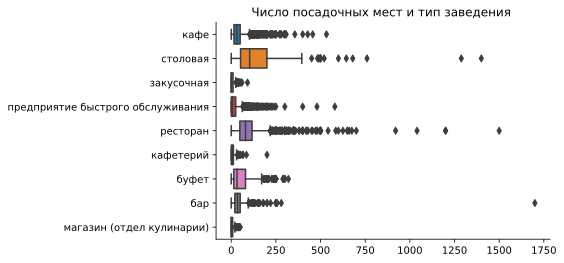

In [58]:
# Посмотрим на распределение по типам и среднему количеству мест 
ax = sns.boxplot(data=rest, x='seats', y='type')
ax.set(
    title='Число посадочных мест и тип заведения ',
    xlabel='',
    ylabel=''
)
sns.despine()
plt.show()

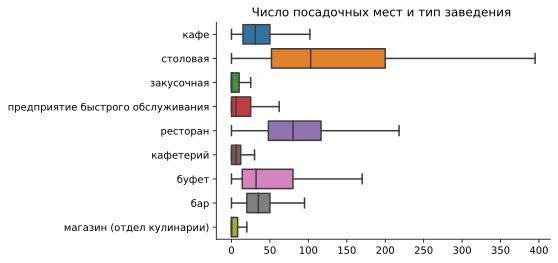

In [59]:
# И без выбросов
ax = sns.boxplot(data=rest, x='seats', y='type', showfliers=False)
ax.set(
    title='Число посадочных мест и тип заведения ',
    xlabel='',
    ylabel=''
)
sns.despine()
plt.show()

Самые вместительные — столовые, от них не сильно отстают рестораны, нередко включают залы вместительностью под 100 человек.

Кафе и бары обычно размером на 20-50 мест.

Буфеты обычно меньше баров и кафе, но в их вместительности бОльший разброс, нередко можно встретить буфеты и больше, чем на 50 человек. 

Самые мальнькие: отделы кулинарии в магазинах, закусочные, кафетерии и пбо.

### 3.4. География 

In [60]:
# Посмотрим на структуру адресов
# addresses = rest_clear['address'].str.lower().sort_values().unique()
print(*rest['address'].sort_values().unique(), sep='\n')

1 нагатинский проезд дом 10
1 тверскаямская улица дом 29/66 корпус 1
2 брестская улица дом 1 строение 1
2 брестская улица дом 5 строение 1
5 котельнический переулок дом 11
алтуфьевское шоссе дом 52а
бауманская улица дом 7 строение 3
большая бронная улица дом 20/1/27 строение 2
большая серпуховская улица дом 48 строение 2
варшавское шоссе владение 99а
вознесенский переулок дом 7 строение 1
вспольный переулок дом 19/20 строение 1
город москва 1 автозаводский проезд дом 4 корпус 1
город москва 1 автозаводский проезд дом 5
город москва 1 амбулаторный проезд дом 2 строение 2
город москва 1 амбулаторный проезд дом 8 строение 1
город москва 1 аэропортовская улица дом 1 строение 3
город москва 1 басманный переулок дом 3 строение 1
город москва 1 боевская улица дом 6
город москва 1 ботанический проезд дом 2
город москва 1 боткинский проезд дом 2/6
город москва 1 боткинский проезд дом 7 строение 1
город москва 1 боткинский проезд дом 9
город москва 1 брестская улица дом 10 строение 4
город москв

город москва ботаническая улица дом 17 корпус 2
город москва ботаническая улица дом 21
город москва ботаническая улица дом 29 корпус 1
город москва ботаническая улица дом 29 корпус 2
город москва ботаническая улица дом 29 корпус 3
город москва ботаническая улица дом 41 корпус 7
город москва ботаническая улица дом 9а строение 1
город москва ботаническая улица домовладение 25 строение 1
город москва ботанический переулок дом 5
город москва братеевская улица дом 16 корпус 3
город москва братеевская улица дом 18
город москва братеевская улица дом 23 корпус 4
город москва братеевская улица дом 31а
город москва братеевская улица дом 8 корпус 2
город москва братиславская улица дом 12
город москва братиславская улица дом 13 корпус 1
город москва братиславская улица дом 14
город москва братиславская улица дом 15 корпус 1
город москва братиславская улица дом 16 корпус 1
город москва братиславская улица дом 16 корпус 2
город москва братиславская улица дом 20
город москва братиславская улица дом 2

город москва дмитровское шоссе дом 13а
город москва дмитровское шоссе дом 15 корпус 1
город москва дмитровское шоссе дом 151 корпус 5
город москва дмитровское шоссе дом 155 корпус 1
город москва дмитровское шоссе дом 157
город москва дмитровское шоссе дом 161б
город москва дмитровское шоссе дом 163 строение 8
город москва дмитровское шоссе дом 163а корпус 1
город москва дмитровское шоссе дом 163а корпус 2
город москва дмитровское шоссе дом 165 корпус 1
город москва дмитровское шоссе дом 165б
город москва дмитровское шоссе дом 165е корпус 8
город москва дмитровское шоссе дом 165е корпус 9
город москва дмитровское шоссе дом 171
город москва дмитровское шоссе дом 27 корпус 1
город москва дмитровское шоссе дом 30 корпус 1
город москва дмитровское шоссе дом 38 корпус 1
город москва дмитровское шоссе дом 45 корпус 1
город москва дмитровское шоссе дом 46 корпус 1
город москва дмитровское шоссе дом 47
город москва дмитровское шоссе дом 48 корпус 1
город москва дмитровское шоссе дом 5 корпус 1


город москва коломенский проезд дом 7б
город москва коломенский проезд дом 8 корпус 5
город москва кольская улица дом 12 строение 24
город москва кольская улица дом 2 корпус 4
город москва композиторская улица дом 17
город москва комсомольская площадь дом 2
город москва комсомольская площадь дом 2а
город москва комсомольская площадь дом 2б
город москва комсомольская площадь дом 3
город москва комсомольская площадь дом 4 строение 1
город москва комсомольская площадь дом 5 строение 2
город москва комсомольская площадь дом 5а строение 1
город москва комсомольская площадь дом 6 сооружение 1
город москва комсомольский проспект дом 13
город москва комсомольский проспект дом 14/1 корпус 1
город москва комсомольский проспект дом 14/1 корпус 2
город москва комсомольский проспект дом 17
город москва комсомольский проспект дом 21/10
город москва комсомольский проспект дом 24 строение 1
город москва комсомольский проспект дом 26
город москва комсомольский проспект дом 28
город москва комсомольский

город москва мурановская улица дом 8б
город москва мурманский проезд дом 10
город москва мурманский проезд дом 12
город москва мурманский проезд дом 8
город москва муромская улица дом 1
город москва мытная улица дом 1 строение 1
город москва мытная улица дом 46 строение 6
город москва мытная улица дом 50 корпус 3
город москва мытная улица дом 50 строение 3
город москва мытная улица дом 58
город москва мытная улица дом 74
город москва мясницкая улица дом 10 строение 1
город москва мясницкая улица дом 11
город москва мясницкая улица дом 13 строение 1
город москва мясницкая улица дом 13 строение 11
город москва мясницкая улица дом 13 строение 20
город москва мясницкая улица дом 13 строение 3
город москва мясницкая улица дом 14/2 строение 1
город москва мясницкая улица дом 15
город москва мясницкая улица дом 16
город москва мясницкая улица дом 17 строение 1
город москва мясницкая улица дом 18 строение 1
город москва мясницкая улица дом 22 строение 1
город москва мясницкая улица дом 24/7 ст

город москва поселение новофедоровское деревня руднево дом 1б/н
город москва поселение новофедоровское деревня яковлевское дом 132
город москва поселение первомайское деревня горчаково школьная улица дом 1а
город москва поселение первомайское деревня поповка дорожная улица дом 12 строение 1
город москва поселение первомайское деревня рогозинино луговая улица домовладение 20а строение 1
город москва поселение первомайское деревня рогозинино луговая улица домовладение 20а строение 3
город москва поселение первомайское деревня фоминское лесная улица владение 14
город москва поселение первомайское поселок первомайское рабочая улица дом 9 строение 1
город москва поселение роговское деревня бунчиха владение 1
город москва поселение роговское деревня каменка дом 1б/н
город москва поселение роговское деревня каменка центральная улица владение 30
город москва поселение роговское поселок рогово дом 2б/н
город москва поселение роговское поселок рогово школьная улица дом 5а
город москва поселение 

город москва скобелевская улица дом 30
город москва скобелевская улица дом 4
город москва сколковское шоссе дом 31 строение 1
город москва сколковское шоссе дом 31 строение 2
город москва сколковское шоссе дом 32
город москва сколковское шоссе дом 32 корпус 1
город москва скорняжный переулок дом 3 строение 1
город москва славянская площадь дом 2/5/4 строение 3
город москва славянский бульвар дом 11 корпус 1
город москва славянский бульвар дом 5 корпус 1 строение 3
город москва славянский бульвар дом 9 корпус 1
город москва смирновская улица дом 10 строение 1
город москва смирновская улица дом 2 строение 1
город москва смирновская улица дом 25 строение 4
город москва смоленская площадь дом 3
город москва смоленская площадь дом 6
город москва смоленская сенная площадь дом 23/25
город москва смоленская сенная площадь дом 27 строение 1
город москва смоленская сенная площадь дом 27 строение 1а
город москва смоленская улица дом 3
город москва смоленская улица дом 5
город москва смоленская ул

город москва улица куусинена дом 19а
город москва улица куусинена дом 4 корпус 1
город москва улица куусинена дом 4а корпус 1
город москва улица куусинена дом 8а
город москва улица кухмистерова дом 20 корпус 2
город москва улица лавочкина дом 19 строение 2
город москва улица лавочкина дом 34
город москва улица лазо дом 7
город москва улица лазо дом 9а
город москва улица лапина дом 3
город москва улица ленинская слобода владение 26 строение 2
город москва улица ленинская слобода дом 17
город москва улица ленинская слобода дом 17 строение 2
город москва улица ленинская слобода дом 19
город москва улица ленинская слобода дом 19 корпус 2
город москва улица ленинская слобода дом 19 строение 1
город москва улица ленинская слобода дом 19 строение 2
город москва улица ленинская слобода дом 23
город москва улица ленинская слобода дом 23 строение 16
город москва улица ленинская слобода дом 26
город москва улица ленинская слобода дом 26 строение 2
город москва улица ленинская слобода дом 26 строе

город москва улица федосьино дом 16 корпус 3 строение 1
город москва улица федосьино дом 18 корпус 1 строение 1
город москва улица федосьино дом 4 строение 2
город москва улица фомичевой дом 1 корпус 1
город москва улица фомичевой дом 1а
город москва улица фомичевой дом 5
город москва улица фомичевой дом 8
город москва улица фонвизина дом 17
город москва улица фотиевой дом 14 корпус 1
город москва улица фотиевой дом 14 корпус 3
город москва улица фридриха энгельса дом 20 строение 1
город москва улица фридриха энгельса дом 20 строение 2
город москва улица фридриха энгельса дом 21
город москва улица фридриха энгельса дом 23 строение 4
город москва улица фридриха энгельса дом 3 5 строение 1
город москва улица фридриха энгельса дом 3 5 строение 2
город москва улица фридриха энгельса дом 75 строение 3
город москва улица фридриха энгельса дом 79 строение 1
город москва улица хамовнический вал дом 10а
город москва улица хамовнический вал дом 2
город москва улица хамовнический вал дом 26
город

In [61]:
def get_street(string):
    
    """ Функция получает строку с адресом, возвращает строку с улицей,
        Для районов без улиц, вроде Зеленограда, возвращает название самого района
    """
    
    special_areas = ['город зеленоград ',
                     'микрорайон северное чертаново ',
                     'квартал волжский бульвар ',
                    ]
    
    suffixes = [' дом ',
                ' владение ',
                ' домовладение ',
               ]
    
    for suffix in suffixes:
        if string.rsplit(suffix)[0] != string:
            return string.rsplit(suffix)[0]

    for area in special_areas:
        if area in string:
            return area[0:len(area)-1]    
    
    return 'error' # Для отладки

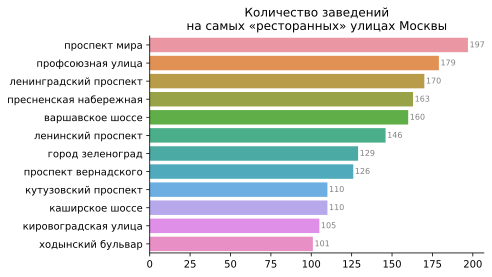

In [62]:
# Добавим столбец с улицой в датафрейм и найдём, те, где больше всего общепитов
rest['street'] = (
    rest['address']
    .str.replace('город москва ', '')
    .apply(get_street)
)

streets = rest['street'].value_counts().reset_index()
streets.columns = ['street', 'points']

# Построим диаграмму
hbarplot(
    streets.head(12),
    y='street',
    x='points',
    title='Количество заведений\nна самых «ресторанных» улицах Москвы',

    fontsize=8,
    up_margin=.27,
    right_margin=1,
    
    grid=False,
    bar_values='value',
)

Чаще всего в топе — очень длинные улицы, уходящие от центра вдоль линий метро. 

Но есть две улицы, не похожие на остальные, они довольно небольшие и находятся около сосредоточения голодных людей: 
- Пресненская Набережнная — около Москвы-сити;
- Ходынский бульвар — торговый центр и Ходынский парк.

In [63]:
# Проверим, что функция корректно отработала по всем адресам
rest[rest['street'] == 'error']['address']

Series([], Name: address, dtype: object)

In [64]:
from io import BytesIO
import requests
spreadsheet_id = '1iYycRIHpyd2eA7SndpD4G4z0o0F-TQo80eSWqxtRZHE'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
areas = pd.read_csv(BytesIO(r.content))

areas.info()
areas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   streetname  4398 non-null   object
 1   areaid      4398 non-null   int64 
 2   okrug       4398 non-null   object
 3   area        4398 non-null   object
dtypes: int64(1), object(3)
memory usage: 137.6+ KB


streetname  areaid okrug               area
0  Выставочный переулок             17      ЦАО   Пресненский район
1  улица Гашека                     17      ЦАО   Пресненский район
2  Большая Никитская улица          17      ЦАО   Пресненский район
3  Глубокий переулок                17      ЦАО   Пресненский район
4  Большой Гнездниковский переулок  17      ЦАО   Пресненский район

In [65]:
# Выполним те же преобразования с адресом areas, что и в rest
areas.columns = ['street', 'area_id', 'district', 'area']

areas['street'] = areas['street'].str.lower()

simple_str(areas, [
    'street',
],{
    '-я': '',
    '-й': '',
})
areas.sample(10)

street  area_id district                      area
4071  улица гагарина             133      ЮЗАО     Район Южное Бутово      
486   валовая улица              14       ЦАО      Район Замоскворечье     
1689  улица чапаева              43       ЗАО      Район Внуково           
597   моховая улица              12       ЦАО      Район Арбат             
2921  2 пехотный переулок        93       СЗАО     Район Щукино            
3854  проспект 60 летия октября  123      ЮЗАО     Академический район     
3003  бирюлевская улица          95       ЮАО      Район Бирюлево Восточное
3316  1 нагатинский проезд       102      ЮАО      Район Нагатино-Садовники
2441  улица слепнева             75       СВАО     Район Лианозово         
1016  ткацкая улица              36       ВАО      Район Соколиная Гора

In [66]:
# Проверим на наличие явных дубликатов
areas.duplicated().sum()

8

In [67]:
# Посмотрим на них глазами
areas[areas.duplicated(keep=False)]

street  area_id    district           area
1654  луговая улица      43       ЗАО         Район Внуково
1655  луговая улица      43       ЗАО         Район Внуково
1662  октябрьская улица  43       ЗАО         Район Внуково
1664  октябрьская улица  43       ЗАО         Район Внуково
1680  советская улица    43       ЗАО         Район Внуково
1681  советская улица    43       ЗАО         Район Внуково
1686  центральная улица  43       ЗАО         Район Внуково
1687  центральная улица  43       ЗАО         Район Внуково
1688  центральная улица  43       ЗАО         Район Внуково
1693  заводская улица    51       Зеленоград  Район Крюково
1695  заводская улица    51       Зеленоград  Район Крюково
1706  лесная улица       51       Зеленоград  Район Крюково
1708  лесная улица       51       Зеленоград  Район Крюково
1743  школьная улица     51       Зеленоград  Район Крюково
1744  школьная улица     51       Зеленоград  Район Крюково

In [68]:
# Удалим задублированные строчки 
areas.drop_duplicates(inplace=True)
areas.duplicated().sum()

0

In [69]:
# Проверим нет ли дубликатов в парах улица-район
areas[['street', 'area']].duplicated().sum()

0

In [70]:
# Проверим на дубликаты названия улиц
areas['street'].duplicated(keep=False).sum()

1333

In [71]:
# Посмотрим на них
areas[areas['street'].duplicated(keep=False)].sort_values('street').head(10)

street  area_id district                        area
805   1 басманный переулок     13       ЦАО      Басманный район           
4213  1 басманный переулок     15       ЦАО      Красносельский район      
4056  1 добрынинский переулок  21       ЦАО      Район Якиманка            
492   1 добрынинский переулок  14       ЦАО      Район Замоскворечье       
165   1 дубровская улица       18       ЦАО      Таганский район           
3416  1 дубровская улица       122      ЮВАО     Южнопортовый Район        
4328  1 коптельский переулок   16       ЦАО      Мещанский район           
4235  1 коптельский переулок   15       ЦАО      Красносельский район      
3089  1 котляковский переулок  107      ЮАО      Район Царицыно            
3294  1 котляковский переулок  101      ЮАО      Район Москворечье-Сабурово

У нас 1333 из 4398 записей про те улицы, которые могут проходить сразу через несколько районов. 

Это много, так что если встретим заведение не такой улице, просто будем записывать его и в тот и в тот район с весом 1/n, где n — количество районов, через которые проходит эта улица. 

In [72]:
# Добавим к улицам информацию, через сколько районов они проходят, рассчитаем вес
streets = streets.merge(
    areas.groupby('street', as_index=False)['area']
    .count(), on='street', how='left'
)
streets['area_weights'] = 1 / streets['area']
streets

street  \
0     проспект мира                                                                
1     профсоюзная улица                                                            
2     ленинградский проспект                                                       
3     пресненская набережная                                                       
4     варшавское шоссе                                                             
...                ...                                                             
2027  поселение новофедоровское деревня рассудово улица рассудовское лесничество   
2028  1 гражданская улица                                                          
2029  2 неопалимовский переулок                                                    
2030  2 иртышский проезд                                                           
2031  поселение марушкинское киевское шоссе 37 километр                            

      points  area  area_weights  
0     197     7.0   0.142857      
1     179     6.0   0.166667      
2     170     4.0   0.250000      
3     163     1.0   1.000000      
4     160     8.0   0.125000      
...   ...     ...        ...      
2027  1      NaN   NaN            
2028  1       1.0   1.000000      
2029  1       1.0   1.000000      
2030  1       1.0   1.000000      
2031  1      NaN   NaN            

[2032 rows x 4 columns]

In [73]:
# Создадим датафрейм со всеми парами улиц и районов исследуемых заведений, добавим к ним вес
rest_areas = (
    rest[['street']].merge(areas[['street', 'area']], on='street', how='left')
    .merge(streets[['street', 'area_weights']], on='street', how='left')
)
rest_areas['area_weights'].fillna(0, inplace=True) # если не нашлось района, вес — 0

rest_areas.head()

street                 area  area_weights
0  улица егора абакумова  Ярославский Район    1.000000    
1  улица талалихина       Таганский район      0.333333    
2  улица талалихина       Нижегородский район  0.333333    
3  улица талалихина       Район Южное Бутово   0.333333    
4  абельмановская улица   Таганский район      1.000000

In [74]:
# Посмотрим, для скольки точек не определился район
rest_areas[rest_areas['area'].isna()].shape[0]

817

У 817 из 15366 записей не определился район, это чуть больше 5%, для наших целей это приемлемо.

In [75]:
# Удалим точки без района
rest_areas.dropna(inplace=True)

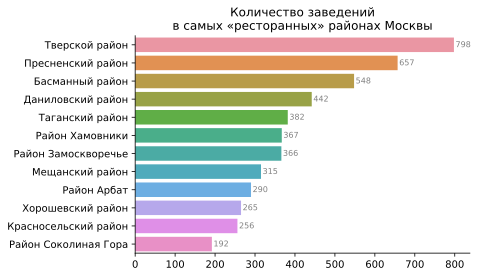

In [76]:
# Посчитаем, сколько точек в каждом районе и покажем на диаграмме
areas_points = (
    rest_areas.groupby('area', as_index=False)
    .agg({'area_weights': 'sum'})
    .sort_values('area_weights', ascending=False)
)

areas_points.columns = ['area', 'points']

areas_points['points'] = areas_points['points'].round().astype('int')

hbarplot(
    areas_points.head(12),
    y='area',
    x='points',
    title='Количество заведений\nв самых «ресторанных» районах Москвы',

    fontsize=8,
    up_margin=.27,
    right_margin=4,
    
    grid=False,
    bar_values='value',
)

Больше всего заведений в Тверском, Пресненском и Басманном районах.

In [77]:
# Найдём улицы с ровно одним заведением общественного питания
streets_1point = streets.query("points == 1").dropna()

print(streets_1point.shape[0])
streets_1point.sample(5)

520


street  points  area  area_weights
1822  таможенный проезд         1       1.0   1.0         
1411  1 чоботовская аллея       1       1.0   1.0         
1575  нововладыкинский проезд   1       1.0   1.0         
1489  брошевский переулок       1       1.0   1.0         
1750  бескудниковский переулок  1       1.0   1.0

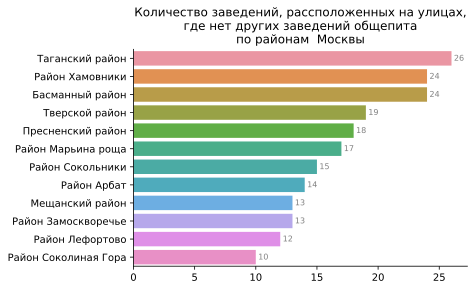

In [78]:
# Посмотрим, в каких районах находятся эти точки, проиллюстрируем на диаграмме
areas_1points = (
    rest_areas
    .query("street in @streets_1point['street']")
    .groupby('area', as_index=False)
    .agg({'area_weights': 'sum'})
    .sort_values('area_weights', ascending=False)
)

areas_1points.columns = ['area', 'points']

areas_1points['points'] = areas_1points['points'].round().astype('int')

hbarplot(
    areas_1points.head(12),
    y='area',
    x='points',
    title='Количество заведений, рассположенных на улицах,\nгде нет других заведений общепита\nпо районам  Москвы',

    fontsize=8,
    up_margin=.27,
    right_margin=0.2,
    
    grid=False,
    bar_values='value',
)

Топ районов, где есть улицы только с одним заведением совпадает по содержанию с топом самых ресторанных районов, это центральные районы Москвы. Возможно это поможет найти ешё «не занятую» улицу для кафе. Но для уверенного выбора нужно смотреть данные о проходимости и соотношении оценки рентабельности, которая будет зависеть и от арендной ставки в конкретном месте.

## 4. Выводы

### 4.1. Данные
В данных большая путанница с признаком сетей и их названиями, пропусков не было.
Было найдено значительное количество дубликатов и сомнительных данных, часть данных исправлена, часть — удалена. 
Для определения района была использована база Мосгаза, для 5% точек не нашлось соответствие району. 

### 4.2. Результат анализа

#### 4.2.1. Типы заведений 
Кафе — самый популярный общепит.

Самые вместительные — столовые, от них не сильно отстают рестораны, нередко включают залы вместительностью под 100 человек.

Кафе и бары обычно размером на 20-50 мест.

Буфеты обычно меньше баров и кафе, но в их вместительности бОльший разброс, нередко можно встретить буфеты и больше, чем на 50 человек.

Самые мальнькие: отделы кулинарии в магазинах, закусочные, кафетерии и пбо.

#### 4.2.2. Cети

1/5 заведений — сетевые. 

Сетевое распространение характерно для предприятий быстрого обслуживания: 42% пбо — сетевые.

Но хоть всего четверть кафе — сетевые, в абсолютном значении их почти в 2 раза больше, чем пбо (≈1500 к 800).

В типином заведении мест примерно столько же, сколько в сетевом.

Но есть некоторое количество уникальных одиночных заведений, в которых очень много мест, иногда больше 1000. Сетевые заведения таким размером похвастаться не могут.

Для сетевых заведений характерно не очень много заведений (до 10) и очень небольшое количество мест (до 100).

#### 4.2.3. География
Чаще всего в топе — очень длинные улицы, уходящие от центра вдоль линий метро. 

Но есть две улицы, не похожие на остальные, они довольно небольшие и находятся около сосредоточения голодных людей: 
- Пресненская Набережнная — около Москвы-сити;
- Ходынский бульвар — торговый центр и Ходынский парк.

Самые ресторанные — центральные районы москвы.
Больше всего заведений в Тверском, Пресненском и Басманном районах.

### 4.3. Рекомендации
Кафе — самое популярное заведение общественного питания в Москве, заказчик сделал удачный выбор типа заведения.

Стоит открывать кафе около мест скопления людей, идеально — на Пресненской набережной около Москвы-сити или на Ходынском бульваре. Но совсем не обязательно, близость к метро и нахождение на проходных популярных улицах — тоже может быть залогом успеха. На окраинах куда реже встречаются точки общепита, но с другой стороны, тут сильно легче конкурировать.

В типичном кафе от 20 до 50 посадочных мест.
Сетевые заведения чаще всего имеют примерно такое же, как и одиночные заведения, число мест. Так что вполне можно начать с одного заведения, отладить процессы и потом развиться в сеть. 

[Презентация](https://www.dropbox.com/s/i6ikvttcfzdckoo/%D0%A0%D1%8B%D0%BD%D0%BE%D0%BA%20%D0%B7%D0%B0%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B9%20%D0%BE%D0%B1%D1%89%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE%20%D0%BF%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D1%8F%20%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B.pdf?dl=0)